In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [33]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 3 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)



# 3 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)


ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 72, 256)      14592       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 72, 284)      0           input_2[0][0]                    
                                                                 conv1d_2[0][0]             

Epoch 1/8000


2023-01-05 23:29:58.286116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-05 23:29:58.494192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-05 23:29:59.644365: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-05 23:30:00.013515: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.04410, saving model to saved_model/ws_pararcnn_sc1_2layer_24h.h5
151/151 - 35s - loss: 0.0630 - mae: 0.0541 - val_loss: 0.0434 - val_mae: 0.0441
Epoch 2/8000

Epoch 00002: val_mae improved from 0.04410 to 0.03472, saving model to saved_model/ws_pararcnn_sc1_2layer_24h.h5
151/151 - 12s - loss: 0.0338 - mae: 0.0233 - val_loss: 0.0289 - val_mae: 0.0347
Epoch 3/8000

Epoch 00003: val_mae improved from 0.03472 to 0.02923, saving model to saved_model/ws_pararcnn_sc1_2layer_24h.h5
151/151 - 12s - loss: 0.0238 - mae: 0.0178 - val_loss: 0.0212 - val_mae: 0.0292
Epoch 4/8000

Epoch 00004: val_mae improved from 0.02923 to 0.02653, saving model to saved_model/ws_pararcnn_sc1_2layer_24h.h5
151/151 - 12s - loss: 0.0179 - mae: 0.0154 - val_loss: 0.0165 - val_mae: 0.0265
Epoch 5/8000

Epoch 00005: val_mae did not improve from 0.02653
151/151 - 12s - loss: 0.0140 - mae: 0.0138 - val_loss: 0.0135 - val_mae: 0.0285
Epoch 6/8000

Epoch 00006: val_mae did not im

Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01549
151/151 - 11s - loss: 2.4798e-04 - mae: 0.0082 - val_loss: 5.2382e-04 - val_mae: 0.0155
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01549
151/151 - 12s - loss: 2.4584e-04 - mae: 0.0081 - val_loss: 5.8814e-04 - val_mae: 0.0167
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.01549
151/151 - 11s - loss: 2.4410e-04 - mae: 0.0080 - val_loss: 5.6772e-04 - val_mae: 0.0165
Epoch 52/8000

Epoch 00052: val_mae did not improve from 0.01549
151/151 - 12s - loss: 2.4642e-04 - mae: 0.0081 - val_loss: 5.3126e-04 - val_mae: 0.0158
Epoch 53/8000

Epoch 00053: val_mae did not improve from 0.01549
151/151 - 12s - loss: 2.4292e-04 - mae: 0.0080 - val_loss: 5.4548e-04 - val_mae: 0.0159
Epoch 54/8000

Epoch 00054: val_mae did not improve from 0.01549
151/151 - 12s - loss: 2.4626e-04 - mae: 0.0081 - val_loss: 5.8744e-04 - val_mae: 0.0167
Epoch 55/8000

Epoch 00055: val_mae did not improve from 0.01549
151/151 - 12s - l

Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01384
151/151 - 13s - loss: 2.2220e-04 - mae: 0.0076 - val_loss: 4.5344e-04 - val_mae: 0.0144
Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.01384
151/151 - 12s - loss: 2.2518e-04 - mae: 0.0078 - val_loss: 5.5885e-04 - val_mae: 0.0161
Epoch 104/8000

Epoch 00104: val_mae did not improve from 0.01384
151/151 - 12s - loss: 2.2110e-04 - mae: 0.0076 - val_loss: 4.9354e-04 - val_mae: 0.0151
Epoch 105/8000

Epoch 00105: val_mae did not improve from 0.01384
151/151 - 13s - loss: 2.2143e-04 - mae: 0.0076 - val_loss: 5.3689e-04 - val_mae: 0.0159
Epoch 106/8000

Epoch 00106: val_mae did not improve from 0.01384
151/151 - 13s - loss: 2.1932e-04 - mae: 0.0075 - val_loss: 4.3750e-04 - val_mae: 0.0140
Epoch 107/8000

Epoch 00107: val_mae did not improve from 0.01384
151/151 - 13s - loss: 2.1728e-04 - mae: 0.0075 - val_loss: 5.7261e-04 - val_mae: 0.0164
Epoch 108/8000

Epoch 00108: val_mae did not improve from 0.01384
151/151 - 

Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.01328
151/151 - 13s - loss: 2.1248e-04 - mae: 0.0074 - val_loss: 5.1622e-04 - val_mae: 0.0157
Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.01328
151/151 - 13s - loss: 2.1069e-04 - mae: 0.0074 - val_loss: 5.5816e-04 - val_mae: 0.0163
Epoch 157/8000

Epoch 00157: val_mae did not improve from 0.01328
151/151 - 13s - loss: 2.1418e-04 - mae: 0.0075 - val_loss: 5.2365e-04 - val_mae: 0.0158
Epoch 158/8000

Epoch 00158: val_mae improved from 0.01328 to 0.01314, saving model to saved_model/ws_pararcnn_sc1_2layer_24h.h5
151/151 - 13s - loss: 2.1179e-04 - mae: 0.0074 - val_loss: 3.9525e-04 - val_mae: 0.0131
Epoch 159/8000

Epoch 00159: val_mae did not improve from 0.01314
151/151 - 13s - loss: 2.1163e-04 - mae: 0.0074 - val_loss: 4.5590e-04 - val_mae: 0.0145
Epoch 160/8000

Epoch 00160: val_mae did not improve from 0.01314
151/151 - 13s - loss: 2.0953e-04 - mae: 0.0073 - val_loss: 5.0865e-04 - val_mae: 0.0154
Epoch 161/800

Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0504e-04 - mae: 0.0073 - val_loss: 4.6980e-04 - val_mae: 0.0146
Epoch 209/8000

Epoch 00209: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0444e-04 - mae: 0.0072 - val_loss: 3.9101e-04 - val_mae: 0.0132
Epoch 210/8000

Epoch 00210: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0652e-04 - mae: 0.0073 - val_loss: 4.3654e-04 - val_mae: 0.0140
Epoch 211/8000

Epoch 00211: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0326e-04 - mae: 0.0072 - val_loss: 4.0531e-04 - val_mae: 0.0134
Epoch 212/8000

Epoch 00212: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0129e-04 - mae: 0.0071 - val_loss: 4.5836e-04 - val_mae: 0.0146
Epoch 213/8000

Epoch 00213: val_mae did not improve from 0.01266
151/151 - 13s - loss: 2.0466e-04 - mae: 0.0073 - val_loss: 4.6549e-04 - val_mae: 0.0145
Epoch 214/8000

Epoch 00214: val_mae did not improve from 0.01266
151/151 - 

Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9794e-04 - mae: 0.0071 - val_loss: 3.9451e-04 - val_mae: 0.0133
Epoch 262/8000

Epoch 00262: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9685e-04 - mae: 0.0070 - val_loss: 4.1739e-04 - val_mae: 0.0135
Epoch 263/8000

Epoch 00263: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9849e-04 - mae: 0.0071 - val_loss: 4.2328e-04 - val_mae: 0.0141
Epoch 264/8000

Epoch 00264: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9958e-04 - mae: 0.0071 - val_loss: 4.0680e-04 - val_mae: 0.0134
Epoch 265/8000

Epoch 00265: val_mae did not improve from 0.01225
151/151 - 13s - loss: 2.0236e-04 - mae: 0.0073 - val_loss: 5.0325e-04 - val_mae: 0.0152
Epoch 266/8000

Epoch 00266: val_mae did not improve from 0.01225
151/151 - 13s - loss: 2.0087e-04 - mae: 0.0072 - val_loss: 4.2440e-04 - val_mae: 0.0136
Epoch 267/8000

Epoch 00267: val_mae did not improve from 0.01225
151/151 - 

Epoch 315/8000

Epoch 00315: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9309e-04 - mae: 0.0069 - val_loss: 4.4161e-04 - val_mae: 0.0141
Epoch 316/8000

Epoch 00316: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9615e-04 - mae: 0.0071 - val_loss: 4.0747e-04 - val_mae: 0.0135
Epoch 317/8000

Epoch 00317: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9542e-04 - mae: 0.0070 - val_loss: 3.7867e-04 - val_mae: 0.0129
Epoch 318/8000

Epoch 00318: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9746e-04 - mae: 0.0071 - val_loss: 4.4319e-04 - val_mae: 0.0140
Epoch 319/8000

Epoch 00319: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9572e-04 - mae: 0.0071 - val_loss: 4.4929e-04 - val_mae: 0.0141
Epoch 320/8000

Epoch 00320: val_mae did not improve from 0.01225
151/151 - 13s - loss: 1.9328e-04 - mae: 0.0070 - val_loss: 4.3722e-04 - val_mae: 0.0140
Epoch 321/8000

Epoch 00321: val_mae did not improve from 0.01225
151/151 - 

Epoch 368/8000

Epoch 00368: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.9335e-04 - mae: 0.0070 - val_loss: 4.3343e-04 - val_mae: 0.0138
Epoch 369/8000

Epoch 00369: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.9231e-04 - mae: 0.0069 - val_loss: 4.6650e-04 - val_mae: 0.0146
Epoch 370/8000

Epoch 00370: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.9177e-04 - mae: 0.0069 - val_loss: 3.9950e-04 - val_mae: 0.0134
Epoch 371/8000

Epoch 00371: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.9508e-04 - mae: 0.0071 - val_loss: 4.7837e-04 - val_mae: 0.0149
Epoch 372/8000

Epoch 00372: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.9130e-04 - mae: 0.0069 - val_loss: 4.0306e-04 - val_mae: 0.0133
Epoch 373/8000

Epoch 00373: val_mae did not improve from 0.01219
151/151 - 13s - loss: 1.8924e-04 - mae: 0.0068 - val_loss: 4.1770e-04 - val_mae: 0.0140
Epoch 374/8000

Epoch 00374: val_mae did not improve from 0.01219
151/151 - 

151/151 - 13s - loss: 1.9029e-04 - mae: 0.0069 - val_loss: 3.3585e-04 - val_mae: 0.0118
Epoch 421/8000

Epoch 00421: val_mae did not improve from 0.01177
151/151 - 13s - loss: 1.9126e-04 - mae: 0.0070 - val_loss: 3.5848e-04 - val_mae: 0.0127
Epoch 422/8000

Epoch 00422: val_mae did not improve from 0.01177
151/151 - 13s - loss: 1.8855e-04 - mae: 0.0069 - val_loss: 3.8183e-04 - val_mae: 0.0131
Epoch 423/8000

Epoch 00423: val_mae did not improve from 0.01177
151/151 - 13s - loss: 1.8852e-04 - mae: 0.0069 - val_loss: 3.6013e-04 - val_mae: 0.0126
Epoch 424/8000

Epoch 00424: val_mae did not improve from 0.01177
151/151 - 13s - loss: 1.8874e-04 - mae: 0.0069 - val_loss: 4.2073e-04 - val_mae: 0.0139
Epoch 425/8000

Epoch 00425: val_mae did not improve from 0.01177
151/151 - 13s - loss: 1.9158e-04 - mae: 0.0070 - val_loss: 3.9167e-04 - val_mae: 0.0132
Epoch 426/8000

Epoch 00426: val_mae did not improve from 0.01177
151/151 - 14s - loss: 1.8585e-04 - mae: 0.0067 - val_loss: 3.6348e-04 - val_

Epoch 473/8000

Epoch 00473: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8747e-04 - mae: 0.0068 - val_loss: 4.0024e-04 - val_mae: 0.0133
Epoch 474/8000

Epoch 00474: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8777e-04 - mae: 0.0069 - val_loss: 4.1407e-04 - val_mae: 0.0139
Epoch 475/8000

Epoch 00475: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8698e-04 - mae: 0.0068 - val_loss: 4.5485e-04 - val_mae: 0.0142
Epoch 476/8000

Epoch 00476: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8888e-04 - mae: 0.0069 - val_loss: 4.3461e-04 - val_mae: 0.0140
Epoch 477/8000

Epoch 00477: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8622e-04 - mae: 0.0068 - val_loss: 3.7566e-04 - val_mae: 0.0129
Epoch 478/8000

Epoch 00478: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8794e-04 - mae: 0.0069 - val_loss: 3.8695e-04 - val_mae: 0.0131
Epoch 479/8000

Epoch 00479: val_mae did not improve from 0.01086
151/151 - 

Epoch 527/8000

Epoch 00527: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8404e-04 - mae: 0.0067 - val_loss: 3.8579e-04 - val_mae: 0.0129
Epoch 528/8000

Epoch 00528: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8575e-04 - mae: 0.0068 - val_loss: 4.0841e-04 - val_mae: 0.0136
Epoch 529/8000

Epoch 00529: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8675e-04 - mae: 0.0069 - val_loss: 3.9938e-04 - val_mae: 0.0132
Epoch 530/8000

Epoch 00530: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8568e-04 - mae: 0.0068 - val_loss: 4.2547e-04 - val_mae: 0.0135
Epoch 531/8000

Epoch 00531: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8505e-04 - mae: 0.0068 - val_loss: 4.3784e-04 - val_mae: 0.0140
Epoch 532/8000

Epoch 00532: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8340e-04 - mae: 0.0067 - val_loss: 4.3615e-04 - val_mae: 0.0140
Epoch 533/8000

Epoch 00533: val_mae did not improve from 0.01086
151/151 - 

Epoch 581/8000

Epoch 00581: val_mae did not improve from 0.01086
151/151 - 14s - loss: 1.8300e-04 - mae: 0.0067 - val_loss: 3.5476e-04 - val_mae: 0.0125
Epoch 582/8000

Epoch 00582: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8134e-04 - mae: 0.0067 - val_loss: 4.5280e-04 - val_mae: 0.0142
Epoch 583/8000

Epoch 00583: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8488e-04 - mae: 0.0068 - val_loss: 3.4822e-04 - val_mae: 0.0125
Epoch 584/8000

Epoch 00584: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8184e-04 - mae: 0.0067 - val_loss: 2.9417e-04 - val_mae: 0.0111
Epoch 585/8000

Epoch 00585: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8232e-04 - mae: 0.0067 - val_loss: 4.5234e-04 - val_mae: 0.0139
Epoch 586/8000

Epoch 00586: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8364e-04 - mae: 0.0067 - val_loss: 3.8439e-04 - val_mae: 0.0129
Epoch 587/8000

Epoch 00587: val_mae did not improve from 0.01086
151/151 - 

Epoch 635/8000

Epoch 00635: val_mae did not improve from 0.01086
151/151 - 14s - loss: 1.8216e-04 - mae: 0.0067 - val_loss: 3.6607e-04 - val_mae: 0.0126
Epoch 636/8000

Epoch 00636: val_mae did not improve from 0.01086
151/151 - 14s - loss: 1.8538e-04 - mae: 0.0069 - val_loss: 4.5774e-04 - val_mae: 0.0141
Epoch 637/8000

Epoch 00637: val_mae did not improve from 0.01086
151/151 - 14s - loss: 1.8368e-04 - mae: 0.0068 - val_loss: 3.3470e-04 - val_mae: 0.0120
Epoch 638/8000

Epoch 00638: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.7900e-04 - mae: 0.0066 - val_loss: 4.4217e-04 - val_mae: 0.0142
Epoch 639/8000

Epoch 00639: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.7914e-04 - mae: 0.0066 - val_loss: 3.9721e-04 - val_mae: 0.0133
Epoch 640/8000

Epoch 00640: val_mae did not improve from 0.01086
151/151 - 13s - loss: 1.8465e-04 - mae: 0.0068 - val_loss: 4.0274e-04 - val_mae: 0.0134
Epoch 641/8000

Epoch 00641: val_mae did not improve from 0.01086
151/151 - 

Epoch 689/8000

Epoch 00689: val_mae did not improve from 0.01086
151/151 - 19s - loss: 1.8059e-04 - mae: 0.0067 - val_loss: 3.5143e-04 - val_mae: 0.0122
Epoch 690/8000

Epoch 00690: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.8101e-04 - mae: 0.0067 - val_loss: 3.6693e-04 - val_mae: 0.0128
Epoch 691/8000

Epoch 00691: val_mae did not improve from 0.01086
151/151 - 16s - loss: 1.7891e-04 - mae: 0.0066 - val_loss: 4.2499e-04 - val_mae: 0.0138
Epoch 692/8000

Epoch 00692: val_mae did not improve from 0.01086
151/151 - 16s - loss: 1.7907e-04 - mae: 0.0066 - val_loss: 3.1088e-04 - val_mae: 0.0114
Epoch 693/8000

Epoch 00693: val_mae did not improve from 0.01086
151/151 - 16s - loss: 1.7867e-04 - mae: 0.0066 - val_loss: 3.6287e-04 - val_mae: 0.0125
Epoch 694/8000

Epoch 00694: val_mae did not improve from 0.01086
151/151 - 16s - loss: 1.8060e-04 - mae: 0.0067 - val_loss: 4.1305e-04 - val_mae: 0.0135
Epoch 695/8000

Epoch 00695: val_mae did not improve from 0.01086
151/151 - 

Epoch 743/8000

Epoch 00743: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7843e-04 - mae: 0.0066 - val_loss: 3.6340e-04 - val_mae: 0.0123
Epoch 744/8000

Epoch 00744: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7912e-04 - mae: 0.0066 - val_loss: 3.8994e-04 - val_mae: 0.0126
Epoch 745/8000

Epoch 00745: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7854e-04 - mae: 0.0066 - val_loss: 3.2127e-04 - val_mae: 0.0115
Epoch 746/8000

Epoch 00746: val_mae did not improve from 0.01086
151/151 - 16s - loss: 1.7924e-04 - mae: 0.0067 - val_loss: 4.0067e-04 - val_mae: 0.0131
Epoch 747/8000

Epoch 00747: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7877e-04 - mae: 0.0066 - val_loss: 4.0644e-04 - val_mae: 0.0134
Epoch 748/8000

Epoch 00748: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7749e-04 - mae: 0.0066 - val_loss: 3.8852e-04 - val_mae: 0.0134
Epoch 749/8000

Epoch 00749: val_mae did not improve from 0.01086
151/151 - 

Epoch 797/8000

Epoch 00797: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7516e-04 - mae: 0.0065 - val_loss: 3.3312e-04 - val_mae: 0.0119
Epoch 798/8000

Epoch 00798: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7702e-04 - mae: 0.0066 - val_loss: 3.7422e-04 - val_mae: 0.0129
Epoch 799/8000

Epoch 00799: val_mae did not improve from 0.01086
151/151 - 18s - loss: 1.7686e-04 - mae: 0.0066 - val_loss: 3.9099e-04 - val_mae: 0.0128
Epoch 800/8000

Epoch 00800: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7870e-04 - mae: 0.0067 - val_loss: 3.4059e-04 - val_mae: 0.0121
Epoch 801/8000

Epoch 00801: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7567e-04 - mae: 0.0065 - val_loss: 3.2780e-04 - val_mae: 0.0119
Epoch 802/8000

Epoch 00802: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7951e-04 - mae: 0.0067 - val_loss: 3.3114e-04 - val_mae: 0.0119
Epoch 803/8000

Epoch 00803: val_mae did not improve from 0.01086
151/151 - 

Epoch 851/8000

Epoch 00851: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7521e-04 - mae: 0.0065 - val_loss: 3.7573e-04 - val_mae: 0.0127
Epoch 852/8000

Epoch 00852: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7598e-04 - mae: 0.0066 - val_loss: 3.8925e-04 - val_mae: 0.0132
Epoch 853/8000

Epoch 00853: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7665e-04 - mae: 0.0066 - val_loss: 3.4997e-04 - val_mae: 0.0124
Epoch 854/8000

Epoch 00854: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7476e-04 - mae: 0.0065 - val_loss: 3.5562e-04 - val_mae: 0.0122
Epoch 855/8000

Epoch 00855: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7610e-04 - mae: 0.0066 - val_loss: 4.6194e-04 - val_mae: 0.0143
Epoch 856/8000

Epoch 00856: val_mae did not improve from 0.01086
151/151 - 17s - loss: 1.7933e-04 - mae: 0.0067 - val_loss: 3.7884e-04 - val_mae: 0.0128
Epoch 857/8000

Epoch 00857: val_mae did not improve from 0.01086
151/151 - 

Epoch 904/8000

Epoch 00904: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7506e-04 - mae: 0.0065 - val_loss: 3.4134e-04 - val_mae: 0.0121
Epoch 905/8000

Epoch 00905: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7506e-04 - mae: 0.0066 - val_loss: 3.5499e-04 - val_mae: 0.0121
Epoch 906/8000

Epoch 00906: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7600e-04 - mae: 0.0066 - val_loss: 3.9788e-04 - val_mae: 0.0130
Epoch 907/8000

Epoch 00907: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7410e-04 - mae: 0.0065 - val_loss: 4.2029e-04 - val_mae: 0.0137
Epoch 908/8000

Epoch 00908: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7574e-04 - mae: 0.0066 - val_loss: 3.6106e-04 - val_mae: 0.0124
Epoch 909/8000

Epoch 00909: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7407e-04 - mae: 0.0065 - val_loss: 4.4080e-04 - val_mae: 0.0138
Epoch 910/8000

Epoch 00910: val_mae did not improve from 0.01081
151/151 - 

Epoch 958/8000

Epoch 00958: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7399e-04 - mae: 0.0065 - val_loss: 3.3719e-04 - val_mae: 0.0117
Epoch 959/8000

Epoch 00959: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7562e-04 - mae: 0.0066 - val_loss: 4.0593e-04 - val_mae: 0.0133
Epoch 960/8000

Epoch 00960: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7392e-04 - mae: 0.0065 - val_loss: 3.6792e-04 - val_mae: 0.0126
Epoch 961/8000

Epoch 00961: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7433e-04 - mae: 0.0065 - val_loss: 3.5709e-04 - val_mae: 0.0125
Epoch 962/8000

Epoch 00962: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7408e-04 - mae: 0.0065 - val_loss: 3.9524e-04 - val_mae: 0.0129
Epoch 963/8000

Epoch 00963: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7322e-04 - mae: 0.0065 - val_loss: 3.4818e-04 - val_mae: 0.0123
Epoch 964/8000

Epoch 00964: val_mae did not improve from 0.01081
151/151 - 

Epoch 1012/8000

Epoch 01012: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7255e-04 - mae: 0.0065 - val_loss: 3.5459e-04 - val_mae: 0.0124
Epoch 1013/8000

Epoch 01013: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7270e-04 - mae: 0.0065 - val_loss: 3.7544e-04 - val_mae: 0.0127
Epoch 1014/8000

Epoch 01014: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7411e-04 - mae: 0.0066 - val_loss: 3.1153e-04 - val_mae: 0.0115
Epoch 1015/8000

Epoch 01015: val_mae did not improve from 0.01081
151/151 - 15s - loss: 1.7110e-04 - mae: 0.0064 - val_loss: 3.5302e-04 - val_mae: 0.0124
Epoch 1016/8000

Epoch 01016: val_mae did not improve from 0.01081
151/151 - 16s - loss: 1.7342e-04 - mae: 0.0065 - val_loss: 3.2522e-04 - val_mae: 0.0116
Epoch 1017/8000

Epoch 01017: val_mae did not improve from 0.01081
151/151 - 17s - loss: 1.7308e-04 - mae: 0.0065 - val_loss: 4.4237e-04 - val_mae: 0.0138
Epoch 1018/8000

Epoch 01018: val_mae did not improve from 0.01081
151

Epoch 1065/8000

Epoch 01065: val_mae did not improve from 0.01075
151/151 - 17s - loss: 1.7015e-04 - mae: 0.0064 - val_loss: 4.0416e-04 - val_mae: 0.0134
Epoch 1066/8000

Epoch 01066: val_mae did not improve from 0.01075
151/151 - 17s - loss: 1.7108e-04 - mae: 0.0064 - val_loss: 3.4925e-04 - val_mae: 0.0123
Epoch 1067/8000

Epoch 01067: val_mae did not improve from 0.01075
151/151 - 16s - loss: 1.7253e-04 - mae: 0.0065 - val_loss: 3.0557e-04 - val_mae: 0.0113
Epoch 1068/8000

Epoch 01068: val_mae did not improve from 0.01075
151/151 - 15s - loss: 1.7315e-04 - mae: 0.0065 - val_loss: 3.5365e-04 - val_mae: 0.0121
Epoch 1069/8000

Epoch 01069: val_mae did not improve from 0.01075
151/151 - 15s - loss: 1.7219e-04 - mae: 0.0065 - val_loss: 2.8375e-04 - val_mae: 0.0110
Epoch 1070/8000

Epoch 01070: val_mae did not improve from 0.01075
151/151 - 15s - loss: 1.7285e-04 - mae: 0.0065 - val_loss: 3.2895e-04 - val_mae: 0.0119
Epoch 1071/8000

Epoch 01071: val_mae did not improve from 0.01075
151


Epoch 01117: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7155e-04 - mae: 0.0065 - val_loss: 3.5992e-04 - val_mae: 0.0124
Epoch 1118/8000

Epoch 01118: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6895e-04 - mae: 0.0064 - val_loss: 4.4679e-04 - val_mae: 0.0140
Epoch 1119/8000

Epoch 01119: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7075e-04 - mae: 0.0064 - val_loss: 3.5618e-04 - val_mae: 0.0122
Epoch 1120/8000

Epoch 01120: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7008e-04 - mae: 0.0064 - val_loss: 3.2226e-04 - val_mae: 0.0116
Epoch 1121/8000

Epoch 01121: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7110e-04 - mae: 0.0064 - val_loss: 3.1721e-04 - val_mae: 0.0118
Epoch 1122/8000

Epoch 01122: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7049e-04 - mae: 0.0064 - val_loss: 5.2115e-04 - val_mae: 0.0146
Epoch 1123/8000

Epoch 01123: val_mae did not improve from 0.01058
151/151 - 15s - los

Epoch 1170/8000

Epoch 01170: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6952e-04 - mae: 0.0064 - val_loss: 3.8064e-04 - val_mae: 0.0133
Epoch 1171/8000

Epoch 01171: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.7171e-04 - mae: 0.0065 - val_loss: 3.3653e-04 - val_mae: 0.0121
Epoch 1172/8000

Epoch 01172: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6950e-04 - mae: 0.0064 - val_loss: 3.5555e-04 - val_mae: 0.0125
Epoch 1173/8000

Epoch 01173: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7069e-04 - mae: 0.0064 - val_loss: 3.6974e-04 - val_mae: 0.0130
Epoch 1174/8000

Epoch 01174: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6854e-04 - mae: 0.0064 - val_loss: 3.6335e-04 - val_mae: 0.0127
Epoch 1175/8000

Epoch 01175: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6973e-04 - mae: 0.0064 - val_loss: 3.6144e-04 - val_mae: 0.0124
Epoch 1176/8000

Epoch 01176: val_mae did not improve from 0.01058
151

Epoch 1223/8000

Epoch 01223: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6885e-04 - mae: 0.0064 - val_loss: 3.8044e-04 - val_mae: 0.0129
Epoch 1224/8000

Epoch 01224: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6853e-04 - mae: 0.0064 - val_loss: 3.5366e-04 - val_mae: 0.0123
Epoch 1225/8000

Epoch 01225: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6777e-04 - mae: 0.0063 - val_loss: 4.1903e-04 - val_mae: 0.0137
Epoch 1226/8000

Epoch 01226: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.7080e-04 - mae: 0.0065 - val_loss: 3.6632e-04 - val_mae: 0.0123
Epoch 1227/8000

Epoch 01227: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6780e-04 - mae: 0.0063 - val_loss: 3.0387e-04 - val_mae: 0.0113
Epoch 1228/8000

Epoch 01228: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6837e-04 - mae: 0.0064 - val_loss: 3.4520e-04 - val_mae: 0.0124
Epoch 1229/8000

Epoch 01229: val_mae did not improve from 0.01058
151

Epoch 1276/8000

Epoch 01276: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6854e-04 - mae: 0.0064 - val_loss: 3.1753e-04 - val_mae: 0.0117
Epoch 1277/8000

Epoch 01277: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6697e-04 - mae: 0.0063 - val_loss: 3.6740e-04 - val_mae: 0.0131
Epoch 1278/8000

Epoch 01278: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.6689e-04 - mae: 0.0063 - val_loss: 4.1190e-04 - val_mae: 0.0137
Epoch 1279/8000

Epoch 01279: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.6839e-04 - mae: 0.0064 - val_loss: 3.6241e-04 - val_mae: 0.0126
Epoch 1280/8000

Epoch 01280: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.6666e-04 - mae: 0.0063 - val_loss: 3.1411e-04 - val_mae: 0.0119
Epoch 1281/8000

Epoch 01281: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6796e-04 - mae: 0.0064 - val_loss: 3.6977e-04 - val_mae: 0.0127
Epoch 1282/8000

Epoch 01282: val_mae did not improve from 0.01058
151

Epoch 1329/8000

Epoch 01329: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6711e-04 - mae: 0.0064 - val_loss: 3.2313e-04 - val_mae: 0.0119
Epoch 1330/8000

Epoch 01330: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6653e-04 - mae: 0.0063 - val_loss: 3.9005e-04 - val_mae: 0.0131
Epoch 1331/8000

Epoch 01331: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6636e-04 - mae: 0.0063 - val_loss: 3.4327e-04 - val_mae: 0.0121
Epoch 1332/8000

Epoch 01332: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6888e-04 - mae: 0.0064 - val_loss: 3.8223e-04 - val_mae: 0.0132
Epoch 1333/8000

Epoch 01333: val_mae did not improve from 0.01058
151/151 - 18s - loss: 1.6781e-04 - mae: 0.0064 - val_loss: 3.2566e-04 - val_mae: 0.0118
Epoch 1334/8000

Epoch 01334: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6575e-04 - mae: 0.0063 - val_loss: 3.3157e-04 - val_mae: 0.0121
Epoch 1335/8000

Epoch 01335: val_mae did not improve from 0.01058
151

Epoch 1382/8000

Epoch 01382: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6768e-04 - mae: 0.0064 - val_loss: 3.6623e-04 - val_mae: 0.0126
Epoch 1383/8000

Epoch 01383: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.6668e-04 - mae: 0.0064 - val_loss: 2.9036e-04 - val_mae: 0.0110
Epoch 1384/8000

Epoch 01384: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6717e-04 - mae: 0.0064 - val_loss: 3.2808e-04 - val_mae: 0.0115
Epoch 1385/8000

Epoch 01385: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6549e-04 - mae: 0.0063 - val_loss: 3.9146e-04 - val_mae: 0.0128
Epoch 1386/8000

Epoch 01386: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6385e-04 - mae: 0.0062 - val_loss: 4.1658e-04 - val_mae: 0.0135
Epoch 1387/8000

Epoch 01387: val_mae did not improve from 0.01058
151/151 - 16s - loss: 1.6633e-04 - mae: 0.0064 - val_loss: 3.2091e-04 - val_mae: 0.0117
Epoch 1388/8000

Epoch 01388: val_mae did not improve from 0.01058
151

Epoch 1435/8000

Epoch 01435: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6779e-04 - mae: 0.0064 - val_loss: 3.2708e-04 - val_mae: 0.0118
Epoch 1436/8000

Epoch 01436: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6596e-04 - mae: 0.0063 - val_loss: 3.3064e-04 - val_mae: 0.0118
Epoch 1437/8000

Epoch 01437: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6539e-04 - mae: 0.0063 - val_loss: 3.5215e-04 - val_mae: 0.0125
Epoch 1438/8000

Epoch 01438: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6565e-04 - mae: 0.0063 - val_loss: 3.5714e-04 - val_mae: 0.0126
Epoch 1439/8000

Epoch 01439: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6455e-04 - mae: 0.0063 - val_loss: 3.9655e-04 - val_mae: 0.0135
Epoch 1440/8000

Epoch 01440: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6614e-04 - mae: 0.0064 - val_loss: 4.1220e-04 - val_mae: 0.0135
Epoch 1441/8000

Epoch 01441: val_mae did not improve from 0.01058
151

Epoch 1488/8000

Epoch 01488: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6370e-04 - mae: 0.0063 - val_loss: 3.7753e-04 - val_mae: 0.0126
Epoch 1489/8000

Epoch 01489: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6374e-04 - mae: 0.0063 - val_loss: 3.3188e-04 - val_mae: 0.0120
Epoch 1490/8000

Epoch 01490: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6531e-04 - mae: 0.0063 - val_loss: 3.4156e-04 - val_mae: 0.0121
Epoch 1491/8000

Epoch 01491: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6681e-04 - mae: 0.0064 - val_loss: 3.0043e-04 - val_mae: 0.0112
Epoch 1492/8000

Epoch 01492: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6347e-04 - mae: 0.0062 - val_loss: 3.4292e-04 - val_mae: 0.0121
Epoch 1493/8000

Epoch 01493: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6409e-04 - mae: 0.0063 - val_loss: 3.4447e-04 - val_mae: 0.0125
Epoch 1494/8000

Epoch 01494: val_mae did not improve from 0.01058
151

Epoch 1541/8000

Epoch 01541: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6513e-04 - mae: 0.0063 - val_loss: 3.4309e-04 - val_mae: 0.0123
Epoch 1542/8000

Epoch 01542: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6274e-04 - mae: 0.0062 - val_loss: 3.8321e-04 - val_mae: 0.0129
Epoch 1543/8000

Epoch 01543: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6589e-04 - mae: 0.0064 - val_loss: 3.6871e-04 - val_mae: 0.0124
Epoch 1544/8000

Epoch 01544: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6253e-04 - mae: 0.0062 - val_loss: 3.8103e-04 - val_mae: 0.0128
Epoch 1545/8000

Epoch 01545: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6445e-04 - mae: 0.0063 - val_loss: 3.3449e-04 - val_mae: 0.0123
Epoch 1546/8000

Epoch 01546: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6375e-04 - mae: 0.0063 - val_loss: 3.8370e-04 - val_mae: 0.0129
Epoch 1547/8000

Epoch 01547: val_mae did not improve from 0.01058
151

Epoch 1594/8000

Epoch 01594: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6175e-04 - mae: 0.0062 - val_loss: 3.7859e-04 - val_mae: 0.0127
Epoch 1595/8000

Epoch 01595: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6289e-04 - mae: 0.0063 - val_loss: 3.7460e-04 - val_mae: 0.0127
Epoch 1596/8000

Epoch 01596: val_mae did not improve from 0.01058
151/151 - 14s - loss: 1.6389e-04 - mae: 0.0063 - val_loss: 3.9801e-04 - val_mae: 0.0128
Epoch 1597/8000

Epoch 01597: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6199e-04 - mae: 0.0062 - val_loss: 3.3535e-04 - val_mae: 0.0120
Epoch 1598/8000

Epoch 01598: val_mae did not improve from 0.01058
151/151 - 15s - loss: 1.6479e-04 - mae: 0.0064 - val_loss: 3.7095e-04 - val_mae: 0.0125
Epoch 1599/8000

Epoch 01599: val_mae did not improve from 0.01058
151/151 - 17s - loss: 1.6347e-04 - mae: 0.0063 - val_loss: 3.6346e-04 - val_mae: 0.0125
Epoch 1600/8000

Epoch 01600: val_mae did not improve from 0.01058
151

Epoch 1647/8000

Epoch 01647: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.5988e-04 - mae: 0.0061 - val_loss: 3.0306e-04 - val_mae: 0.0113
Epoch 1648/8000

Epoch 01648: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6329e-04 - mae: 0.0063 - val_loss: 4.4191e-04 - val_mae: 0.0139
Epoch 1649/8000

Epoch 01649: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6339e-04 - mae: 0.0063 - val_loss: 3.2326e-04 - val_mae: 0.0117
Epoch 1650/8000

Epoch 01650: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6185e-04 - mae: 0.0062 - val_loss: 3.7511e-04 - val_mae: 0.0130
Epoch 1651/8000

Epoch 01651: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6354e-04 - mae: 0.0063 - val_loss: 3.5653e-04 - val_mae: 0.0126
Epoch 1652/8000

Epoch 01652: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6110e-04 - mae: 0.0062 - val_loss: 3.8276e-04 - val_mae: 0.0129
Epoch 1653/8000

Epoch 01653: val_mae did not improve from 0.01058
151

Epoch 1700/8000

Epoch 01700: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.5887e-04 - mae: 0.0061 - val_loss: 3.9231e-04 - val_mae: 0.0133
Epoch 1701/8000

Epoch 01701: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6051e-04 - mae: 0.0062 - val_loss: 4.3274e-04 - val_mae: 0.0140
Epoch 1702/8000

Epoch 01702: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6258e-04 - mae: 0.0063 - val_loss: 2.9858e-04 - val_mae: 0.0111
Epoch 1703/8000

Epoch 01703: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6070e-04 - mae: 0.0062 - val_loss: 3.4973e-04 - val_mae: 0.0122
Epoch 1704/8000

Epoch 01704: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6347e-04 - mae: 0.0063 - val_loss: 3.2178e-04 - val_mae: 0.0116
Epoch 1705/8000

Epoch 01705: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6170e-04 - mae: 0.0062 - val_loss: 3.8465e-04 - val_mae: 0.0128
Epoch 1706/8000

Epoch 01706: val_mae did not improve from 0.01058
151

Epoch 1753/8000

Epoch 01753: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6165e-04 - mae: 0.0063 - val_loss: 3.4518e-04 - val_mae: 0.0122
Epoch 1754/8000

Epoch 01754: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6031e-04 - mae: 0.0062 - val_loss: 3.3887e-04 - val_mae: 0.0122
Epoch 1755/8000

Epoch 01755: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6188e-04 - mae: 0.0063 - val_loss: 2.9358e-04 - val_mae: 0.0111
Epoch 1756/8000

Epoch 01756: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.5993e-04 - mae: 0.0062 - val_loss: 3.1022e-04 - val_mae: 0.0113
Epoch 1757/8000

Epoch 01757: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6034e-04 - mae: 0.0062 - val_loss: 2.9928e-04 - val_mae: 0.0114
Epoch 1758/8000

Epoch 01758: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6176e-04 - mae: 0.0063 - val_loss: 3.4804e-04 - val_mae: 0.0122
Epoch 1759/8000

Epoch 01759: val_mae did not improve from 0.01058
151

Epoch 1806/8000

Epoch 01806: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.5941e-04 - mae: 0.0062 - val_loss: 3.1495e-04 - val_mae: 0.0117
Epoch 1807/8000

Epoch 01807: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6017e-04 - mae: 0.0062 - val_loss: 3.7499e-04 - val_mae: 0.0130
Epoch 1808/8000

Epoch 01808: val_mae did not improve from 0.01058
151/151 - 13s - loss: 1.6157e-04 - mae: 0.0063 - val_loss: 3.4584e-04 - val_mae: 0.0122
Epoch 1809/8000

Epoch 01809: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6114e-04 - mae: 0.0063 - val_loss: 3.6409e-04 - val_mae: 0.0127
Epoch 1810/8000

Epoch 01810: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.5924e-04 - mae: 0.0062 - val_loss: 3.6204e-04 - val_mae: 0.0127
Epoch 1811/8000

Epoch 01811: val_mae did not improve from 0.01058
151/151 - 12s - loss: 1.6035e-04 - mae: 0.0062 - val_loss: 3.9405e-04 - val_mae: 0.0131
Epoch 1812/8000

Epoch 01812: val_mae did not improve from 0.01058
151

Epoch 1859/8000

Epoch 01859: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5882e-04 - mae: 0.0062 - val_loss: 3.5733e-04 - val_mae: 0.0123
Epoch 1860/8000

Epoch 01860: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5996e-04 - mae: 0.0062 - val_loss: 3.8280e-04 - val_mae: 0.0130
Epoch 1861/8000

Epoch 01861: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5894e-04 - mae: 0.0062 - val_loss: 3.5393e-04 - val_mae: 0.0123
Epoch 1862/8000

Epoch 01862: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.6022e-04 - mae: 0.0062 - val_loss: 4.6073e-04 - val_mae: 0.0140
Epoch 1863/8000

Epoch 01863: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5777e-04 - mae: 0.0061 - val_loss: 2.8664e-04 - val_mae: 0.0108
Epoch 1864/8000

Epoch 01864: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.6174e-04 - mae: 0.0063 - val_loss: 3.4166e-04 - val_mae: 0.0122
Epoch 1865/8000

Epoch 01865: val_mae did not improve from 0.01023
151

Epoch 1912/8000

Epoch 01912: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5803e-04 - mae: 0.0061 - val_loss: 3.7681e-04 - val_mae: 0.0123
Epoch 1913/8000

Epoch 01913: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5833e-04 - mae: 0.0062 - val_loss: 3.3640e-04 - val_mae: 0.0121
Epoch 1914/8000

Epoch 01914: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.6044e-04 - mae: 0.0063 - val_loss: 4.0539e-04 - val_mae: 0.0134
Epoch 1915/8000

Epoch 01915: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5921e-04 - mae: 0.0062 - val_loss: 4.1407e-04 - val_mae: 0.0134
Epoch 1916/8000

Epoch 01916: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5837e-04 - mae: 0.0062 - val_loss: 3.5418e-04 - val_mae: 0.0125
Epoch 1917/8000

Epoch 01917: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5694e-04 - mae: 0.0061 - val_loss: 4.1451e-04 - val_mae: 0.0138
Epoch 1918/8000

Epoch 01918: val_mae did not improve from 0.01023
151

Epoch 1965/8000

Epoch 01965: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5697e-04 - mae: 0.0061 - val_loss: 3.8009e-04 - val_mae: 0.0131
Epoch 1966/8000

Epoch 01966: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5877e-04 - mae: 0.0062 - val_loss: 3.7320e-04 - val_mae: 0.0129
Epoch 1967/8000

Epoch 01967: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5947e-04 - mae: 0.0063 - val_loss: 3.5589e-04 - val_mae: 0.0124
Epoch 1968/8000

Epoch 01968: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5920e-04 - mae: 0.0062 - val_loss: 3.0706e-04 - val_mae: 0.0115
Epoch 1969/8000

Epoch 01969: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5662e-04 - mae: 0.0061 - val_loss: 3.5914e-04 - val_mae: 0.0126
Epoch 1970/8000

Epoch 01970: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5849e-04 - mae: 0.0062 - val_loss: 4.6074e-04 - val_mae: 0.0140
Epoch 1971/8000

Epoch 01971: val_mae did not improve from 0.01023
151

Epoch 2018/8000

Epoch 02018: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5799e-04 - mae: 0.0062 - val_loss: 3.0976e-04 - val_mae: 0.0117
Epoch 2019/8000

Epoch 02019: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5815e-04 - mae: 0.0062 - val_loss: 3.5192e-04 - val_mae: 0.0124
Epoch 2020/8000

Epoch 02020: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5567e-04 - mae: 0.0061 - val_loss: 3.3227e-04 - val_mae: 0.0122
Epoch 2021/8000

Epoch 02021: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5786e-04 - mae: 0.0062 - val_loss: 3.2706e-04 - val_mae: 0.0119
Epoch 2022/8000

Epoch 02022: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5539e-04 - mae: 0.0061 - val_loss: 3.4888e-04 - val_mae: 0.0123
Epoch 2023/8000

Epoch 02023: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5721e-04 - mae: 0.0062 - val_loss: 3.4000e-04 - val_mae: 0.0121
Epoch 2024/8000

Epoch 02024: val_mae did not improve from 0.01023
151

Epoch 2071/8000

Epoch 02071: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5696e-04 - mae: 0.0062 - val_loss: 3.3336e-04 - val_mae: 0.0123
Epoch 2072/8000

Epoch 02072: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5580e-04 - mae: 0.0061 - val_loss: 3.2759e-04 - val_mae: 0.0120
Epoch 2073/8000

Epoch 02073: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5613e-04 - mae: 0.0061 - val_loss: 3.4848e-04 - val_mae: 0.0122
Epoch 2074/8000

Epoch 02074: val_mae did not improve from 0.01023
151/151 - 13s - loss: 1.5694e-04 - mae: 0.0062 - val_loss: 3.6821e-04 - val_mae: 0.0127
Epoch 2075/8000

Epoch 02075: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5767e-04 - mae: 0.0062 - val_loss: 3.8361e-04 - val_mae: 0.0127
Epoch 2076/8000

Epoch 02076: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5593e-04 - mae: 0.0061 - val_loss: 3.1622e-04 - val_mae: 0.0119
Epoch 2077/8000

Epoch 02077: val_mae did not improve from 0.01023
151

Epoch 2124/8000

Epoch 02124: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5427e-04 - mae: 0.0061 - val_loss: 4.6756e-04 - val_mae: 0.0141
Epoch 2125/8000

Epoch 02125: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5765e-04 - mae: 0.0062 - val_loss: 3.6950e-04 - val_mae: 0.0128
Epoch 2126/8000

Epoch 02126: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5343e-04 - mae: 0.0060 - val_loss: 3.1990e-04 - val_mae: 0.0117
Epoch 2127/8000

Epoch 02127: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5605e-04 - mae: 0.0061 - val_loss: 3.4430e-04 - val_mae: 0.0122
Epoch 2128/8000

Epoch 02128: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5548e-04 - mae: 0.0061 - val_loss: 3.5085e-04 - val_mae: 0.0122
Epoch 2129/8000

Epoch 02129: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5463e-04 - mae: 0.0061 - val_loss: 4.0320e-04 - val_mae: 0.0136
Epoch 2130/8000

Epoch 02130: val_mae did not improve from 0.01023
151

Epoch 2177/8000

Epoch 02177: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5603e-04 - mae: 0.0062 - val_loss: 3.0391e-04 - val_mae: 0.0116
Epoch 2178/8000

Epoch 02178: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5519e-04 - mae: 0.0061 - val_loss: 3.5528e-04 - val_mae: 0.0123
Epoch 2179/8000

Epoch 02179: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5515e-04 - mae: 0.0061 - val_loss: 3.5658e-04 - val_mae: 0.0123
Epoch 2180/8000

Epoch 02180: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5501e-04 - mae: 0.0061 - val_loss: 3.5943e-04 - val_mae: 0.0127
Epoch 2181/8000

Epoch 02181: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5432e-04 - mae: 0.0061 - val_loss: 4.0402e-04 - val_mae: 0.0130
Epoch 2182/8000

Epoch 02182: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5450e-04 - mae: 0.0061 - val_loss: 3.5958e-04 - val_mae: 0.0128
Epoch 2183/8000

Epoch 02183: val_mae did not improve from 0.01023
151

Epoch 2230/8000

Epoch 02230: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5351e-04 - mae: 0.0060 - val_loss: 3.4861e-04 - val_mae: 0.0125
Epoch 2231/8000

Epoch 02231: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5341e-04 - mae: 0.0061 - val_loss: 3.6095e-04 - val_mae: 0.0126
Epoch 2232/8000

Epoch 02232: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5723e-04 - mae: 0.0063 - val_loss: 3.7464e-04 - val_mae: 0.0130
Epoch 2233/8000

Epoch 02233: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5352e-04 - mae: 0.0060 - val_loss: 3.7025e-04 - val_mae: 0.0127
Epoch 2234/8000

Epoch 02234: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5388e-04 - mae: 0.0061 - val_loss: 3.1229e-04 - val_mae: 0.0116
Epoch 2235/8000

Epoch 02235: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5385e-04 - mae: 0.0061 - val_loss: 3.2984e-04 - val_mae: 0.0120
Epoch 2236/8000

Epoch 02236: val_mae did not improve from 0.01023
151

Epoch 2283/8000

Epoch 02283: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5349e-04 - mae: 0.0061 - val_loss: 3.0329e-04 - val_mae: 0.0115
Epoch 2284/8000

Epoch 02284: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5486e-04 - mae: 0.0061 - val_loss: 3.5224e-04 - val_mae: 0.0126
Epoch 2285/8000

Epoch 02285: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5320e-04 - mae: 0.0061 - val_loss: 3.2435e-04 - val_mae: 0.0120
Epoch 2286/8000

Epoch 02286: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5343e-04 - mae: 0.0061 - val_loss: 3.5867e-04 - val_mae: 0.0127
Epoch 2287/8000

Epoch 02287: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5510e-04 - mae: 0.0062 - val_loss: 2.7070e-04 - val_mae: 0.0106
Epoch 2288/8000

Epoch 02288: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5384e-04 - mae: 0.0061 - val_loss: 3.2879e-04 - val_mae: 0.0120
Epoch 2289/8000

Epoch 02289: val_mae did not improve from 0.01023
151

Epoch 2336/8000

Epoch 02336: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5274e-04 - mae: 0.0060 - val_loss: 3.8345e-04 - val_mae: 0.0125
Epoch 2337/8000

Epoch 02337: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5334e-04 - mae: 0.0061 - val_loss: 3.1485e-04 - val_mae: 0.0118
Epoch 2338/8000

Epoch 02338: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5309e-04 - mae: 0.0061 - val_loss: 3.2014e-04 - val_mae: 0.0118
Epoch 2339/8000

Epoch 02339: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5372e-04 - mae: 0.0061 - val_loss: 3.3445e-04 - val_mae: 0.0123
Epoch 2340/8000

Epoch 02340: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5466e-04 - mae: 0.0061 - val_loss: 2.9239e-04 - val_mae: 0.0113
Epoch 2341/8000

Epoch 02341: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5183e-04 - mae: 0.0060 - val_loss: 3.5529e-04 - val_mae: 0.0124
Epoch 2342/8000

Epoch 02342: val_mae did not improve from 0.01023
151

Epoch 2389/8000

Epoch 02389: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5272e-04 - mae: 0.0061 - val_loss: 3.4404e-04 - val_mae: 0.0123
Epoch 2390/8000

Epoch 02390: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5264e-04 - mae: 0.0061 - val_loss: 3.7030e-04 - val_mae: 0.0127
Epoch 2391/8000

Epoch 02391: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5323e-04 - mae: 0.0061 - val_loss: 3.6699e-04 - val_mae: 0.0128
Epoch 2392/8000

Epoch 02392: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5331e-04 - mae: 0.0061 - val_loss: 3.3080e-04 - val_mae: 0.0120
Epoch 2393/8000

Epoch 02393: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5131e-04 - mae: 0.0060 - val_loss: 3.3351e-04 - val_mae: 0.0122
Epoch 2394/8000

Epoch 02394: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5345e-04 - mae: 0.0061 - val_loss: 3.0996e-04 - val_mae: 0.0118
Epoch 2395/8000

Epoch 02395: val_mae did not improve from 0.01023
151

Epoch 2442/8000

Epoch 02442: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5061e-04 - mae: 0.0060 - val_loss: 3.0927e-04 - val_mae: 0.0115
Epoch 2443/8000

Epoch 02443: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5100e-04 - mae: 0.0060 - val_loss: 3.3915e-04 - val_mae: 0.0120
Epoch 2444/8000

Epoch 02444: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5137e-04 - mae: 0.0060 - val_loss: 3.1142e-04 - val_mae: 0.0118
Epoch 2445/8000

Epoch 02445: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5240e-04 - mae: 0.0061 - val_loss: 3.1743e-04 - val_mae: 0.0116
Epoch 2446/8000

Epoch 02446: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5214e-04 - mae: 0.0061 - val_loss: 2.9963e-04 - val_mae: 0.0115
Epoch 2447/8000

Epoch 02447: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5208e-04 - mae: 0.0061 - val_loss: 3.3266e-04 - val_mae: 0.0118
Epoch 2448/8000

Epoch 02448: val_mae did not improve from 0.01023
151

Epoch 2495/8000

Epoch 02495: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5295e-04 - mae: 0.0061 - val_loss: 3.3403e-04 - val_mae: 0.0120
Epoch 2496/8000

Epoch 02496: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5207e-04 - mae: 0.0061 - val_loss: 3.0719e-04 - val_mae: 0.0116
Epoch 2497/8000

Epoch 02497: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5282e-04 - mae: 0.0061 - val_loss: 2.9747e-04 - val_mae: 0.0115
Epoch 2498/8000

Epoch 02498: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5031e-04 - mae: 0.0060 - val_loss: 3.0239e-04 - val_mae: 0.0112
Epoch 2499/8000

Epoch 02499: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5044e-04 - mae: 0.0060 - val_loss: 3.3089e-04 - val_mae: 0.0121
Epoch 2500/8000

Epoch 02500: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5158e-04 - mae: 0.0060 - val_loss: 3.3931e-04 - val_mae: 0.0121
Epoch 2501/8000

Epoch 02501: val_mae did not improve from 0.01023
151

Epoch 2548/8000

Epoch 02548: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5130e-04 - mae: 0.0061 - val_loss: 4.3523e-04 - val_mae: 0.0138
Epoch 2549/8000

Epoch 02549: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5115e-04 - mae: 0.0061 - val_loss: 2.9581e-04 - val_mae: 0.0113
Epoch 2550/8000

Epoch 02550: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4992e-04 - mae: 0.0060 - val_loss: 3.4755e-04 - val_mae: 0.0124
Epoch 2551/8000

Epoch 02551: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4936e-04 - mae: 0.0060 - val_loss: 3.4012e-04 - val_mae: 0.0121
Epoch 2552/8000

Epoch 02552: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5072e-04 - mae: 0.0060 - val_loss: 3.9888e-04 - val_mae: 0.0132
Epoch 2553/8000

Epoch 02553: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5160e-04 - mae: 0.0061 - val_loss: 3.3022e-04 - val_mae: 0.0121
Epoch 2554/8000

Epoch 02554: val_mae did not improve from 0.01023
151

Epoch 2601/8000

Epoch 02601: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5102e-04 - mae: 0.0061 - val_loss: 3.5624e-04 - val_mae: 0.0124
Epoch 2602/8000

Epoch 02602: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4953e-04 - mae: 0.0060 - val_loss: 2.8285e-04 - val_mae: 0.0110
Epoch 2603/8000

Epoch 02603: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4989e-04 - mae: 0.0060 - val_loss: 3.0901e-04 - val_mae: 0.0115
Epoch 2604/8000

Epoch 02604: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5059e-04 - mae: 0.0060 - val_loss: 3.3686e-04 - val_mae: 0.0121
Epoch 2605/8000

Epoch 02605: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5088e-04 - mae: 0.0061 - val_loss: 3.2654e-04 - val_mae: 0.0119
Epoch 2606/8000

Epoch 02606: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4848e-04 - mae: 0.0059 - val_loss: 3.5491e-04 - val_mae: 0.0123
Epoch 2607/8000

Epoch 02607: val_mae did not improve from 0.01023
151

Epoch 2654/8000

Epoch 02654: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4940e-04 - mae: 0.0060 - val_loss: 3.6041e-04 - val_mae: 0.0125
Epoch 2655/8000

Epoch 02655: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4797e-04 - mae: 0.0059 - val_loss: 3.2714e-04 - val_mae: 0.0119
Epoch 2656/8000

Epoch 02656: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5096e-04 - mae: 0.0061 - val_loss: 2.8450e-04 - val_mae: 0.0110
Epoch 2657/8000

Epoch 02657: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4986e-04 - mae: 0.0060 - val_loss: 3.3952e-04 - val_mae: 0.0122
Epoch 2658/8000

Epoch 02658: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4768e-04 - mae: 0.0059 - val_loss: 2.8947e-04 - val_mae: 0.0112
Epoch 2659/8000

Epoch 02659: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.5129e-04 - mae: 0.0061 - val_loss: 3.5591e-04 - val_mae: 0.0125
Epoch 2660/8000

Epoch 02660: val_mae did not improve from 0.01023
151

Epoch 2707/8000

Epoch 02707: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4863e-04 - mae: 0.0060 - val_loss: 2.5591e-04 - val_mae: 0.0105
Epoch 2708/8000

Epoch 02708: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4968e-04 - mae: 0.0060 - val_loss: 3.7660e-04 - val_mae: 0.0126
Epoch 2709/8000

Epoch 02709: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4777e-04 - mae: 0.0059 - val_loss: 3.1574e-04 - val_mae: 0.0118
Epoch 2710/8000

Epoch 02710: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4994e-04 - mae: 0.0060 - val_loss: 3.0212e-04 - val_mae: 0.0113
Epoch 2711/8000

Epoch 02711: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4796e-04 - mae: 0.0059 - val_loss: 3.3479e-04 - val_mae: 0.0122
Epoch 2712/8000

Epoch 02712: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4926e-04 - mae: 0.0060 - val_loss: 3.1638e-04 - val_mae: 0.0117
Epoch 2713/8000

Epoch 02713: val_mae did not improve from 0.01023
151

Epoch 2760/8000

Epoch 02760: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4669e-04 - mae: 0.0059 - val_loss: 3.1015e-04 - val_mae: 0.0115
Epoch 2761/8000

Epoch 02761: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4690e-04 - mae: 0.0059 - val_loss: 2.9850e-04 - val_mae: 0.0114
Epoch 2762/8000

Epoch 02762: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4853e-04 - mae: 0.0060 - val_loss: 3.1935e-04 - val_mae: 0.0118
Epoch 2763/8000

Epoch 02763: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4792e-04 - mae: 0.0060 - val_loss: 3.9204e-04 - val_mae: 0.0132
Epoch 2764/8000

Epoch 02764: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4917e-04 - mae: 0.0060 - val_loss: 3.8190e-04 - val_mae: 0.0128
Epoch 2765/8000

Epoch 02765: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4839e-04 - mae: 0.0060 - val_loss: 3.0974e-04 - val_mae: 0.0113
Epoch 2766/8000

Epoch 02766: val_mae did not improve from 0.01023
151

Epoch 2813/8000

Epoch 02813: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4893e-04 - mae: 0.0060 - val_loss: 3.2018e-04 - val_mae: 0.0117
Epoch 2814/8000

Epoch 02814: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4735e-04 - mae: 0.0059 - val_loss: 3.7018e-04 - val_mae: 0.0127
Epoch 2815/8000

Epoch 02815: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4869e-04 - mae: 0.0060 - val_loss: 3.1341e-04 - val_mae: 0.0116
Epoch 2816/8000

Epoch 02816: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4644e-04 - mae: 0.0059 - val_loss: 3.3078e-04 - val_mae: 0.0120
Epoch 2817/8000

Epoch 02817: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4636e-04 - mae: 0.0059 - val_loss: 3.2662e-04 - val_mae: 0.0120
Epoch 2818/8000

Epoch 02818: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4848e-04 - mae: 0.0060 - val_loss: 3.5406e-04 - val_mae: 0.0123
Epoch 2819/8000

Epoch 02819: val_mae did not improve from 0.01023
151

Epoch 2866/8000

Epoch 02866: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4686e-04 - mae: 0.0059 - val_loss: 3.2638e-04 - val_mae: 0.0120
Epoch 2867/8000

Epoch 02867: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4772e-04 - mae: 0.0060 - val_loss: 2.9555e-04 - val_mae: 0.0113
Epoch 2868/8000

Epoch 02868: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4754e-04 - mae: 0.0060 - val_loss: 3.1403e-04 - val_mae: 0.0117
Epoch 2869/8000

Epoch 02869: val_mae did not improve from 0.01023
151/151 - 13s - loss: 1.4871e-04 - mae: 0.0060 - val_loss: 3.2568e-04 - val_mae: 0.0119
Epoch 2870/8000

Epoch 02870: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4530e-04 - mae: 0.0059 - val_loss: 3.5937e-04 - val_mae: 0.0127
Epoch 2871/8000

Epoch 02871: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4577e-04 - mae: 0.0059 - val_loss: 3.2933e-04 - val_mae: 0.0122
Epoch 2872/8000

Epoch 02872: val_mae did not improve from 0.01023
151

Epoch 2919/8000

Epoch 02919: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4659e-04 - mae: 0.0059 - val_loss: 3.2844e-04 - val_mae: 0.0117
Epoch 2920/8000

Epoch 02920: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4521e-04 - mae: 0.0059 - val_loss: 2.9190e-04 - val_mae: 0.0112
Epoch 2921/8000

Epoch 02921: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4802e-04 - mae: 0.0060 - val_loss: 3.6826e-04 - val_mae: 0.0126
Epoch 2922/8000

Epoch 02922: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4583e-04 - mae: 0.0059 - val_loss: 3.7076e-04 - val_mae: 0.0128
Epoch 2923/8000

Epoch 02923: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4651e-04 - mae: 0.0059 - val_loss: 3.9181e-04 - val_mae: 0.0129
Epoch 2924/8000

Epoch 02924: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4638e-04 - mae: 0.0059 - val_loss: 3.1502e-04 - val_mae: 0.0118
Epoch 2925/8000

Epoch 02925: val_mae did not improve from 0.01023
151

Epoch 2972/8000

Epoch 02972: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4536e-04 - mae: 0.0059 - val_loss: 3.1862e-04 - val_mae: 0.0119
Epoch 2973/8000

Epoch 02973: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4637e-04 - mae: 0.0059 - val_loss: 3.1216e-04 - val_mae: 0.0117
Epoch 2974/8000

Epoch 02974: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4576e-04 - mae: 0.0059 - val_loss: 3.2714e-04 - val_mae: 0.0119
Epoch 2975/8000

Epoch 02975: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4536e-04 - mae: 0.0059 - val_loss: 3.0618e-04 - val_mae: 0.0115
Epoch 2976/8000

Epoch 02976: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4595e-04 - mae: 0.0059 - val_loss: 3.2721e-04 - val_mae: 0.0118
Epoch 2977/8000

Epoch 02977: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4641e-04 - mae: 0.0060 - val_loss: 3.4079e-04 - val_mae: 0.0122
Epoch 2978/8000

Epoch 02978: val_mae did not improve from 0.01023
151

Epoch 3025/8000

Epoch 03025: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4473e-04 - mae: 0.0059 - val_loss: 3.3237e-04 - val_mae: 0.0120
Epoch 3026/8000

Epoch 03026: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4443e-04 - mae: 0.0059 - val_loss: 2.9412e-04 - val_mae: 0.0112
Epoch 3027/8000

Epoch 03027: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4625e-04 - mae: 0.0060 - val_loss: 2.9535e-04 - val_mae: 0.0114
Epoch 3028/8000

Epoch 03028: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4479e-04 - mae: 0.0059 - val_loss: 3.3459e-04 - val_mae: 0.0121
Epoch 3029/8000

Epoch 03029: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4505e-04 - mae: 0.0059 - val_loss: 3.3092e-04 - val_mae: 0.0121
Epoch 3030/8000

Epoch 03030: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4565e-04 - mae: 0.0059 - val_loss: 3.4399e-04 - val_mae: 0.0125
Epoch 3031/8000

Epoch 03031: val_mae did not improve from 0.01023
151

Epoch 3078/8000

Epoch 03078: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4481e-04 - mae: 0.0059 - val_loss: 3.3796e-04 - val_mae: 0.0122
Epoch 3079/8000

Epoch 03079: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4451e-04 - mae: 0.0059 - val_loss: 3.0651e-04 - val_mae: 0.0117
Epoch 3080/8000

Epoch 03080: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4482e-04 - mae: 0.0059 - val_loss: 2.9314e-04 - val_mae: 0.0113
Epoch 3081/8000

Epoch 03081: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4454e-04 - mae: 0.0059 - val_loss: 3.3751e-04 - val_mae: 0.0121
Epoch 3082/8000

Epoch 03082: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4441e-04 - mae: 0.0059 - val_loss: 3.5234e-04 - val_mae: 0.0122
Epoch 3083/8000

Epoch 03083: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4505e-04 - mae: 0.0059 - val_loss: 2.9924e-04 - val_mae: 0.0114
Epoch 3084/8000

Epoch 03084: val_mae did not improve from 0.01023
151

Epoch 3131/8000

Epoch 03131: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4346e-04 - mae: 0.0058 - val_loss: 2.8733e-04 - val_mae: 0.0112
Epoch 3132/8000

Epoch 03132: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4530e-04 - mae: 0.0059 - val_loss: 2.9384e-04 - val_mae: 0.0113
Epoch 3133/8000

Epoch 03133: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4469e-04 - mae: 0.0059 - val_loss: 3.5784e-04 - val_mae: 0.0124
Epoch 3134/8000

Epoch 03134: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4497e-04 - mae: 0.0059 - val_loss: 3.3023e-04 - val_mae: 0.0124
Epoch 3135/8000

Epoch 03135: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4518e-04 - mae: 0.0059 - val_loss: 3.0586e-04 - val_mae: 0.0116
Epoch 3136/8000

Epoch 03136: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4262e-04 - mae: 0.0058 - val_loss: 3.3838e-04 - val_mae: 0.0123
Epoch 3137/8000

Epoch 03137: val_mae did not improve from 0.01023
151

Epoch 3184/8000

Epoch 03184: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4348e-04 - mae: 0.0059 - val_loss: 2.8794e-04 - val_mae: 0.0112
Epoch 3185/8000

Epoch 03185: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4318e-04 - mae: 0.0059 - val_loss: 3.3810e-04 - val_mae: 0.0123
Epoch 3186/8000

Epoch 03186: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4354e-04 - mae: 0.0059 - val_loss: 3.1855e-04 - val_mae: 0.0118
Epoch 3187/8000

Epoch 03187: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4412e-04 - mae: 0.0059 - val_loss: 3.1148e-04 - val_mae: 0.0115
Epoch 3188/8000

Epoch 03188: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4352e-04 - mae: 0.0059 - val_loss: 3.7522e-04 - val_mae: 0.0125
Epoch 3189/8000

Epoch 03189: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4412e-04 - mae: 0.0059 - val_loss: 2.8615e-04 - val_mae: 0.0110
Epoch 3190/8000

Epoch 03190: val_mae did not improve from 0.01023
151

Epoch 3237/8000

Epoch 03237: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4291e-04 - mae: 0.0059 - val_loss: 3.2386e-04 - val_mae: 0.0119
Epoch 3238/8000

Epoch 03238: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4209e-04 - mae: 0.0058 - val_loss: 3.8467e-04 - val_mae: 0.0130
Epoch 3239/8000

Epoch 03239: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4453e-04 - mae: 0.0059 - val_loss: 3.7564e-04 - val_mae: 0.0128
Epoch 3240/8000

Epoch 03240: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4279e-04 - mae: 0.0059 - val_loss: 3.5436e-04 - val_mae: 0.0125
Epoch 3241/8000

Epoch 03241: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4410e-04 - mae: 0.0059 - val_loss: 3.2912e-04 - val_mae: 0.0121
Epoch 3242/8000

Epoch 03242: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4216e-04 - mae: 0.0058 - val_loss: 3.1294e-04 - val_mae: 0.0117
Epoch 3243/8000

Epoch 03243: val_mae did not improve from 0.01023
151

Epoch 3290/8000

Epoch 03290: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4211e-04 - mae: 0.0058 - val_loss: 3.4427e-04 - val_mae: 0.0122
Epoch 3291/8000

Epoch 03291: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4356e-04 - mae: 0.0059 - val_loss: 3.1691e-04 - val_mae: 0.0119
Epoch 3292/8000

Epoch 03292: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4360e-04 - mae: 0.0059 - val_loss: 3.6876e-04 - val_mae: 0.0128
Epoch 3293/8000

Epoch 03293: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4159e-04 - mae: 0.0058 - val_loss: 3.1685e-04 - val_mae: 0.0118
Epoch 3294/8000

Epoch 03294: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4308e-04 - mae: 0.0059 - val_loss: 3.2323e-04 - val_mae: 0.0117
Epoch 3295/8000

Epoch 03295: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4196e-04 - mae: 0.0058 - val_loss: 3.4948e-04 - val_mae: 0.0124
Epoch 3296/8000

Epoch 03296: val_mae did not improve from 0.01023
151

Epoch 3343/8000

Epoch 03343: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4145e-04 - mae: 0.0058 - val_loss: 3.2722e-04 - val_mae: 0.0118
Epoch 3344/8000

Epoch 03344: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4217e-04 - mae: 0.0058 - val_loss: 3.4506e-04 - val_mae: 0.0125
Epoch 3345/8000

Epoch 03345: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4288e-04 - mae: 0.0059 - val_loss: 3.0763e-04 - val_mae: 0.0117
Epoch 3346/8000

Epoch 03346: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4159e-04 - mae: 0.0058 - val_loss: 3.1020e-04 - val_mae: 0.0118
Epoch 3347/8000

Epoch 03347: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4283e-04 - mae: 0.0059 - val_loss: 2.7270e-04 - val_mae: 0.0108
Epoch 3348/8000

Epoch 03348: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4193e-04 - mae: 0.0058 - val_loss: 3.6966e-04 - val_mae: 0.0129
Epoch 3349/8000

Epoch 03349: val_mae did not improve from 0.01023
151

Epoch 3396/8000

Epoch 03396: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4177e-04 - mae: 0.0059 - val_loss: 3.9597e-04 - val_mae: 0.0133
Epoch 3397/8000

Epoch 03397: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4271e-04 - mae: 0.0059 - val_loss: 3.0998e-04 - val_mae: 0.0115
Epoch 3398/8000

Epoch 03398: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4015e-04 - mae: 0.0058 - val_loss: 3.5522e-04 - val_mae: 0.0124
Epoch 3399/8000

Epoch 03399: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4117e-04 - mae: 0.0058 - val_loss: 3.2278e-04 - val_mae: 0.0118
Epoch 3400/8000

Epoch 03400: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4076e-04 - mae: 0.0058 - val_loss: 3.5945e-04 - val_mae: 0.0126
Epoch 3401/8000

Epoch 03401: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4217e-04 - mae: 0.0059 - val_loss: 2.9236e-04 - val_mae: 0.0112
Epoch 3402/8000

Epoch 03402: val_mae did not improve from 0.01023
151

Epoch 3449/8000

Epoch 03449: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4102e-04 - mae: 0.0058 - val_loss: 3.5575e-04 - val_mae: 0.0125
Epoch 3450/8000

Epoch 03450: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4016e-04 - mae: 0.0058 - val_loss: 3.8428e-04 - val_mae: 0.0129
Epoch 3451/8000

Epoch 03451: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4149e-04 - mae: 0.0058 - val_loss: 3.6991e-04 - val_mae: 0.0127
Epoch 3452/8000

Epoch 03452: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4174e-04 - mae: 0.0059 - val_loss: 2.7599e-04 - val_mae: 0.0110
Epoch 3453/8000

Epoch 03453: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4190e-04 - mae: 0.0059 - val_loss: 3.5351e-04 - val_mae: 0.0125
Epoch 3454/8000

Epoch 03454: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4046e-04 - mae: 0.0058 - val_loss: 2.9588e-04 - val_mae: 0.0115
Epoch 3455/8000

Epoch 03455: val_mae did not improve from 0.01023
151

Epoch 3502/8000

Epoch 03502: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4126e-04 - mae: 0.0059 - val_loss: 2.9893e-04 - val_mae: 0.0115
Epoch 3503/8000

Epoch 03503: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3979e-04 - mae: 0.0058 - val_loss: 3.1282e-04 - val_mae: 0.0116
Epoch 3504/8000

Epoch 03504: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4025e-04 - mae: 0.0058 - val_loss: 3.3604e-04 - val_mae: 0.0122
Epoch 3505/8000

Epoch 03505: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4068e-04 - mae: 0.0058 - val_loss: 3.2859e-04 - val_mae: 0.0120
Epoch 3506/8000

Epoch 03506: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4126e-04 - mae: 0.0059 - val_loss: 2.8927e-04 - val_mae: 0.0111
Epoch 3507/8000

Epoch 03507: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4123e-04 - mae: 0.0059 - val_loss: 3.0273e-04 - val_mae: 0.0116
Epoch 3508/8000

Epoch 03508: val_mae did not improve from 0.01023
151

Epoch 3555/8000

Epoch 03555: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4097e-04 - mae: 0.0059 - val_loss: 3.3849e-04 - val_mae: 0.0120
Epoch 3556/8000

Epoch 03556: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3929e-04 - mae: 0.0058 - val_loss: 3.0236e-04 - val_mae: 0.0115
Epoch 3557/8000

Epoch 03557: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4188e-04 - mae: 0.0059 - val_loss: 3.0716e-04 - val_mae: 0.0118
Epoch 3558/8000

Epoch 03558: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3956e-04 - mae: 0.0058 - val_loss: 3.0108e-04 - val_mae: 0.0116
Epoch 3559/8000

Epoch 03559: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4044e-04 - mae: 0.0058 - val_loss: 3.8596e-04 - val_mae: 0.0133
Epoch 3560/8000

Epoch 03560: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3953e-04 - mae: 0.0058 - val_loss: 2.9713e-04 - val_mae: 0.0113
Epoch 3561/8000

Epoch 03561: val_mae did not improve from 0.01023
151

Epoch 3608/8000

Epoch 03608: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3829e-04 - mae: 0.0057 - val_loss: 3.2981e-04 - val_mae: 0.0121
Epoch 3609/8000

Epoch 03609: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3875e-04 - mae: 0.0058 - val_loss: 3.4018e-04 - val_mae: 0.0123
Epoch 3610/8000

Epoch 03610: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3923e-04 - mae: 0.0058 - val_loss: 3.5323e-04 - val_mae: 0.0125
Epoch 3611/8000

Epoch 03611: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4009e-04 - mae: 0.0058 - val_loss: 3.0501e-04 - val_mae: 0.0117
Epoch 3612/8000

Epoch 03612: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4067e-04 - mae: 0.0059 - val_loss: 2.9755e-04 - val_mae: 0.0114
Epoch 3613/8000

Epoch 03613: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3873e-04 - mae: 0.0058 - val_loss: 3.1408e-04 - val_mae: 0.0119
Epoch 3614/8000

Epoch 03614: val_mae did not improve from 0.01023
151

Epoch 3661/8000

Epoch 03661: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3858e-04 - mae: 0.0058 - val_loss: 2.9429e-04 - val_mae: 0.0115
Epoch 3662/8000

Epoch 03662: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3971e-04 - mae: 0.0058 - val_loss: 3.2709e-04 - val_mae: 0.0121
Epoch 3663/8000

Epoch 03663: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.4008e-04 - mae: 0.0058 - val_loss: 3.3114e-04 - val_mae: 0.0124
Epoch 3664/8000

Epoch 03664: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3926e-04 - mae: 0.0058 - val_loss: 3.4715e-04 - val_mae: 0.0122
Epoch 3665/8000

Epoch 03665: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3875e-04 - mae: 0.0058 - val_loss: 3.1079e-04 - val_mae: 0.0117
Epoch 3666/8000

Epoch 03666: val_mae did not improve from 0.01023
151/151 - 12s - loss: 1.3821e-04 - mae: 0.0057 - val_loss: 2.9510e-04 - val_mae: 0.0112
Epoch 3667/8000

Epoch 03667: val_mae did not improve from 0.01023
151

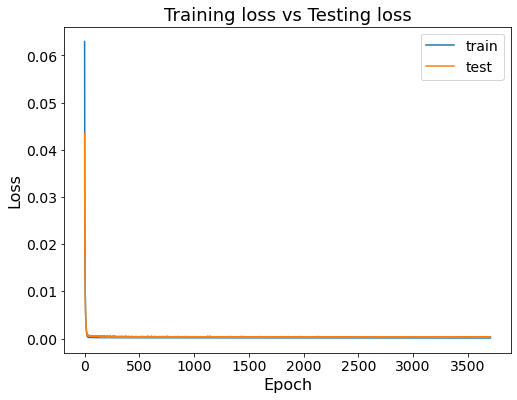

In [34]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_2layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [36]:
# model_load.predict(test_input).shape

### Performance

In [35]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_2layer_{}h.h5'.format(K))

In [36]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [37]:
# inv_y

In [38]:
# inv_yhat

In [39]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0542
RMSE = 0.0755
